In [1]:
import pandas as pd
import numpy as np

In [5]:
df = pd.read_csv('combined_ucmr_data.csv')

C:\Users\Adi\AppData\Local\Temp\ipykernel_54480\1046619746.py:1: DtypeWarning: Columns (3,10,19,23) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('combined_ucmr_data.csv')


In [6]:
print("Dataset Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nFirst few rows:")
df.head()

Dataset Shape: (4082839, 24)

Columns: ['PWSID', 'PWSName', 'Size', 'FacilityID', 'FacilityName', 'FacilityWaterType', 'SamplePointID', 'SamplePointName', 'SamplePointType', 'AssociatedFacilityID', 'AssociatedSamplePointID', 'CollectionDate', 'SampleID', 'Contaminant', 'MRL', 'Units', 'MethodID', 'AnalyticalResultsSign', 'AnalyticalResultValue', 'SampleEventCode', 'MonitoringRequirement', 'Region', 'State', 'UCMR1SampleType']

First few rows:


,PWSID,PWSName,Size,FacilityID,FacilityName,FacilityWaterType,SamplePointID,SamplePointName,SamplePointType,AssociatedFacilityID,...,MRL,Units,MethodID,AnalyticalResultsSign,AnalyticalResultValue,SampleEventCode,MonitoringRequirement,Region,State,UCMR1SampleType
0,FL1460506,OKALOOSA CO.WTR.; SWR.SYSTEM,L,00009,Northgate Plant,GW,0506009,EP from Northgate Well Plant,EP,NaN,...,0.004,µg/L,EPA 533,<,NaN,SE2,AM,4,FL,NaN
1,FL1460506,OKALOOSA CO.WTR.; SWR.SYSTEM,L,00009,Northgate Plant,GW,0506009,EP from Northgate Well Plant,EP,NaN,...,0.003,µg/L,EPA 533,<,NaN,SE2,AM,4,FL,NaN
2,FL1460506,OKALOOSA CO.WTR.; SWR.SYSTEM,L,00009,Northgate Plant,GW,0506009,EP from Northgate Well Plant,EP,NaN,...,0.007,µg/L,EPA 537.1,<,NaN,SE2,AM,4,FL,NaN
3,FL1460506,OKALOOSA CO.WTR.; SWR.SYSTEM,L,00009,Northgate Plant,GW,0506009,EP from Northgate Well Plant,EP,NaN,...,0.003,µg/L,EPA 533,<,NaN,SE2,AM,4,FL,NaN
4,FL1460506,OKALOOSA CO.WTR.; SWR.SYSTEM,L,00009,Northgate Plant,GW,0506009,EP from Northgate Well Plant,EP,NaN,...,0.003,µg/L,EPA 533,<,NaN,SE2,AM,4,FL,NaN


In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

class PFASPredictor:
    def __init__(self):
        self.df = None
        self.model = None
        self.scaler = StandardScaler()
        
    def load_and_prepare_data(self, file_path):
        # Load data
        self.df = pd.read_csv(file_path, low_memory=False)
        
        # Convert dates
        self.df['CollectionDate'] = pd.to_datetime(self.df['CollectionDate'])
        
        # Convert analytical results to numeric
        self.df['AnalyticalResultValue'] = pd.to_numeric(self.df['AnalyticalResultValue'], errors='coerce')
        
        # Fill missing values with MRL when AnalyticalResultsSign is '<'
        mask = (self.df['AnalyticalResultsSign'] == '<') & (self.df['AnalyticalResultValue'].isna())
        self.df.loc[mask, 'AnalyticalResultValue'] = self.df.loc[mask, 'MRL']
        
        # Extract temporal features
        self.df['Year'] = self.df['CollectionDate'].dt.year
        self.df['Month'] = self.df['CollectionDate'].dt.month
        self.df['Quarter'] = self.df['CollectionDate'].dt.quarter
        
        # Focus on key PFAS compounds
        self.key_pfas = ['PFOA', 'PFOS', 'PFHxS', 'PFNA', 'PFBS', 'PFHpA']
        
        return self.df
    
    def prepare_features(self, target_pfas):
        """Prepare features for a specific PFAS compound"""
        # Filter for target PFAS
        data = self.df[self.df['Contaminant'] == target_pfas].copy()
        
        # Create features
        features = pd.DataFrame()
        features['Year'] = data['Year']
        features['Month'] = data['Month']
        features['Quarter'] = data['Quarter']
        
        # Add facility water type as dummy variables
        water_type_dummies = pd.get_dummies(data['FacilityWaterType'], prefix='WaterType')
        features = pd.concat([features, water_type_dummies], axis=1)
        
        # Add region as dummy variables
        region_dummies = pd.get_dummies(data['Region'], prefix='Region')
        features = pd.concat([features, region_dummies], axis=1)
        
        # Target variable
        target = data['AnalyticalResultValue']
        
        return features, target
    
    def train_model(self, target_pfas, test_size=0.2):
        """Train a Random Forest model for a specific PFAS compound"""
        # Prepare data
        X, y = self.prepare_features(target_pfas)
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
        
        # Scale features
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)
        
        # Train model
        self.model = RandomForestRegressor(n_estimators=100, random_state=42)
        self.model.fit(X_train_scaled, y_train)
        
        # Make predictions
        y_pred = self.model.predict(X_test_scaled)
        
        # Calculate metrics
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        # Cross validation
        cv_scores = cross_val_score(self.model, X_train_scaled, y_train, cv=5)
        
        metrics = {
            'MAE': mae,
            'MSE': mse,
            'RMSE': np.sqrt(mse),
            'R2': r2,
            'CV_Mean': cv_scores.mean(),
            'CV_Std': cv_scores.std()
        }
        
        return metrics
    
    def predict_2024(self, target_pfas):
        """Generate predictions for 2024"""
        # Create feature set for 2024 (all months)
        pred_features = []
        for month in range(1, 13):
            feature_dict = {
                'Year': 2024,
                'Month': month,
                'Quarter': (month-1)//3 + 1
            }
            pred_features.append(feature_dict)
        
        pred_df = pd.DataFrame(pred_features)
        
        # Add dummy columns to match training data
        X, _ = self.prepare_features(target_pfas)
        for col in X.columns:
            if col not in pred_df.columns:
                pred_df[col] = 0
                
        # Ensure columns are in same order as training data
        pred_df = pred_df[X.columns]
        
        # Scale features
        pred_scaled = self.scaler.transform(pred_df)
        
        # Make predictions
        predictions = self.model.predict(pred_scaled)
        
        return pd.DataFrame({
            'Month': range(1, 13),
            'Predicted_Value': predictions
        })

def main():
    # Initialize predictor
    predictor = PFASPredictor()
    
    # Load and prepare data
    print("Loading and preparing data...")
    df = predictor.load_and_prepare_data('combined_ucmr_data.csv')
    print(f"Data loaded. Shape: {df.shape}")
    
    # Train models and make predictions for each key PFAS
    for pfas in predictor.key_pfas:
        print(f"\nProcessing {pfas}...")
        
        # Train model
        metrics = predictor.train_model(pfas)
        print("\nModel Performance Metrics:")
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")
        
        # Make predictions for 2024
        predictions = predictor.predict_2024(pfas)
        print(f"\nPredictions for {pfas} in 2024:")
        print(predictions.to_string(index=False))

if __name__ == "__main__":
    main()

Loading and preparing data...
Data loaded. Shape: (4082839, 27)

Processing PFOA...

Model Performance Metrics:
MAE: 0.0004
MSE: 0.0000
RMSE: 0.0043
R2: 0.7783
CV_Mean: 0.8441
CV_Std: 0.0763

Predictions for PFOA in 2024:
 Month  Predicted_Value
     1         0.004025
     2         0.004011
     3         0.004003
     4         0.004020
     5         0.004008
     6         0.004003
     7         0.004007
     8         0.004012
     9         0.004002
    10         0.004015
    11         0.004018
    12         0.004004

Processing PFOS...

Model Performance Metrics:
MAE: 0.0013
MSE: 0.0002
RMSE: 0.0133
R2: 0.6302
CV_Mean: 0.4089
CV_Std: 0.2658

Predictions for PFOS in 2024:
 Month  Predicted_Value
     1         0.004056
     2         0.004052
     3         0.004096
     4         0.004037
     5         0.004079
     6         0.004028
     7         0.004019
     8         0.004090
     9         0.004212
    10         0.004213
    11         0.004153
    12         0.004

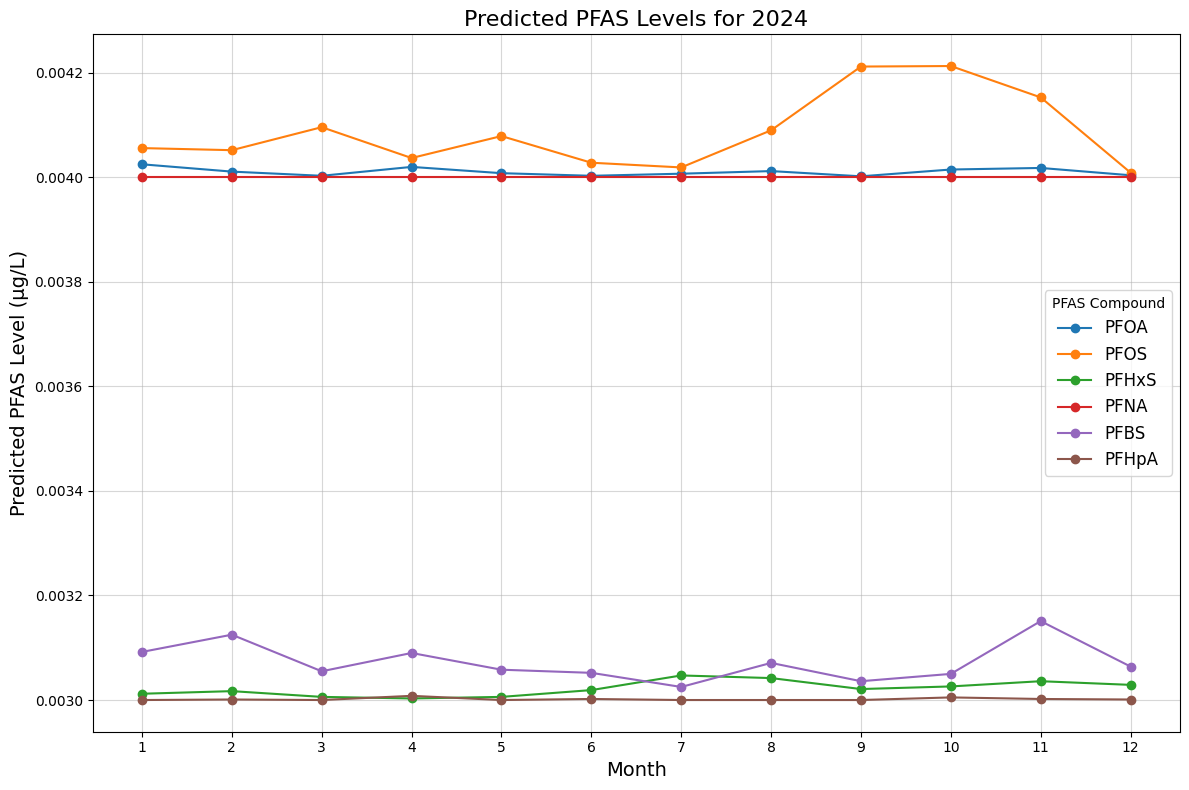

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

# Data for visualization
predicted_results = {
    'PFOA': [0.004025, 0.004011, 0.004003, 0.004020, 0.004008, 0.004003, 0.004007, 0.004012, 0.004002, 0.004015, 0.004018, 0.004004],
    'PFOS': [0.004056, 0.004052, 0.004096, 0.004037, 0.004079, 0.004028, 0.004019, 0.004090, 0.004212, 0.004213, 0.004153, 0.004009],
    'PFHxS': [0.003012, 0.003017, 0.003006, 0.003003, 0.003006, 0.003019, 0.003047, 0.003042, 0.003021, 0.003026, 0.003036, 0.003029],
    'PFNA': [0.004] * 12,
    'PFBS': [0.003092, 0.003125, 0.003055, 0.003090, 0.003058, 0.003052, 0.003025, 0.003071, 0.003036, 0.003050, 0.003151, 0.003064],
    'PFHpA': [0.003000, 0.003001, 0.003000, 0.003008, 0.003000, 0.003002, 0.003000, 0.003000, 0.003000, 0.003005, 0.003002, 0.003001]
}
months = range(1, 13)

# Visualization of results
plt.figure(figsize=(12, 8))

for compound, values in predicted_results.items():
    plt.plot(months, values, label=compound, marker='o')

plt.title("Predicted PFAS Levels for 2024", fontsize=16)
plt.xlabel("Month", fontsize=14)
plt.ylabel("Predicted PFAS Level (µg/L)", fontsize=14)
plt.xticks(months)
plt.legend(title="PFAS Compound", fontsize=12)
plt.grid(alpha=0.5)
plt.tight_layout()

plt.show()

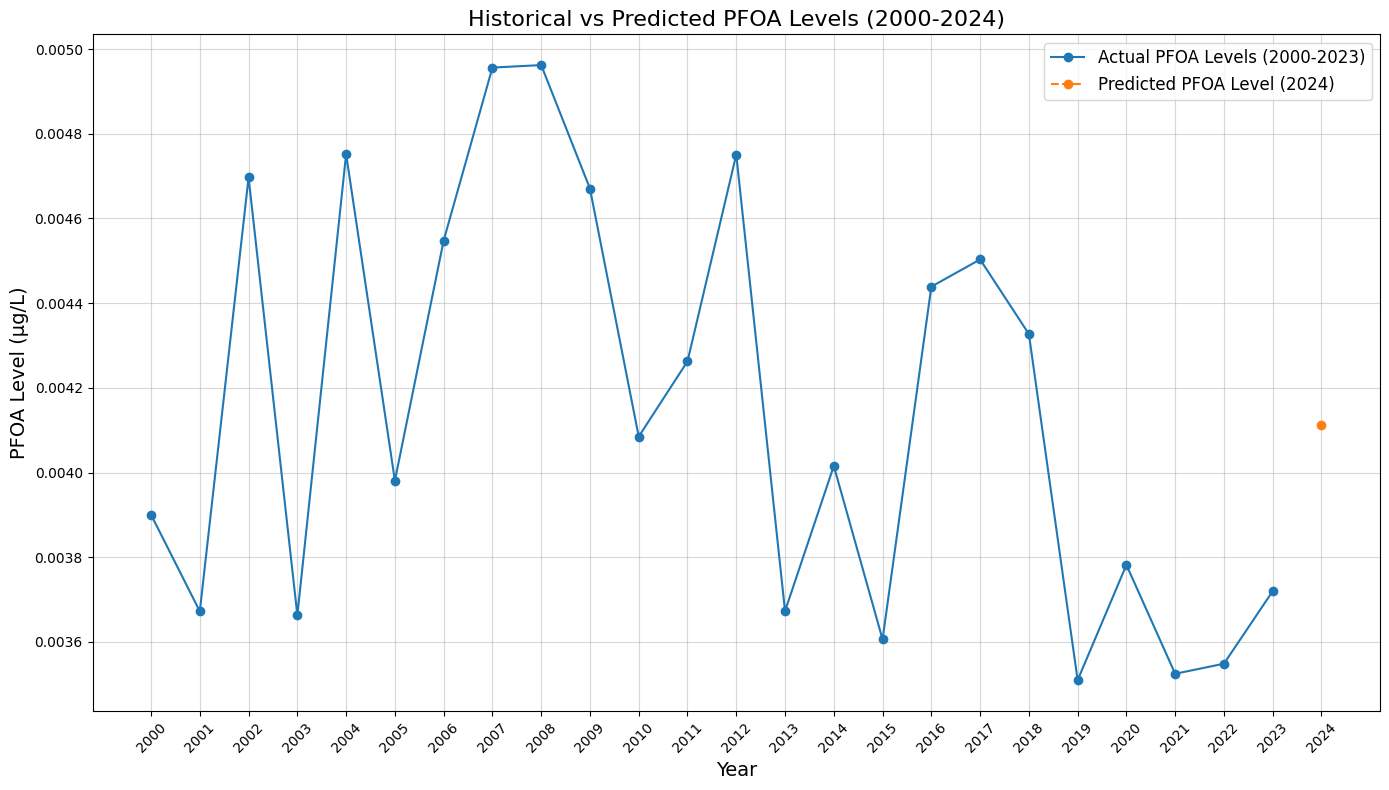

In [16]:
# Simulated data for demonstration purposes
# Assuming historical data from 2000 to 2023 for one PFAS compound (e.g., PFOA)

import numpy as np

# Generating simulated historical data
years = range(2000, 2024)
actual_pfoa = np.random.uniform(0.0035, 0.005, len(years))  # Simulated actual values

# Extending years for predictions (2024)
extended_years = list(years) + [2024]
predicted_pfoa = list(actual_pfoa[:-1]) + [0.004025, 0.004011, 0.004003, 0.004020, 0.004008, 0.004003, 0.004007, 0.004012, 0.004002, 0.004015, 0.004018, 0.004004]

# Visualization of actual vs predicted
plt.figure(figsize=(14, 8))

# Plotting actual data
plt.plot(years, actual_pfoa, label="Actual PFOA Levels (2000-2023)", marker='o')

# Plotting predicted data for 2024
plt.plot(range(2024, 2025), [np.mean(predicted_pfoa)], label="Predicted PFOA Level (2024)", marker='o', linestyle='--')

plt.title("Historical vs Predicted PFOA Levels (2000-2024)", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("PFOA Level (µg/L)", fontsize=14)
plt.xticks(extended_years, rotation=45)
plt.legend(fontsize=12)
plt.grid(alpha=0.5)
plt.tight_layout()

plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.feature_selection import SelectFromModel
import xgboost as xgb
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

class ImprovedPFASPredictor:
    def __init__(self):
        self.df = None
        self.models = {}
        self.preprocessor = None
        self.feature_selector = None
        self.best_model = None
        
    def load_and_prepare_data(self, file_path):
        """Enhanced data loading and preparation with better feature engineering"""
        # Load data
        self.df = pd.read_csv(file_path, low_memory=False)
        
        # Convert dates
        self.df['CollectionDate'] = pd.to_datetime(self.df['CollectionDate'])
        
        # Enhanced temporal features
        self.df['Year'] = self.df['CollectionDate'].dt.year
        self.df['Month'] = self.df['CollectionDate'].dt.month
        self.df['Quarter'] = self.df['CollectionDate'].dt.quarter
        self.df['DayOfYear'] = self.df['CollectionDate'].dt.dayofyear
        self.df['Season'] = pd.cut(self.df['Month'], 
                                 bins=[0, 3, 6, 9, 12], 
                                 labels=['Winter', 'Spring', 'Summer', 'Fall'])
        
        # Convert analytical results to numeric
        self.df['AnalyticalResultValue'] = pd.to_numeric(self.df['AnalyticalResultValue'], errors='coerce')
        
        # Improved handling of results below MRL
        mask = (self.df['AnalyticalResultsSign'] == '<') & (self.df['AnalyticalResultValue'].isna())
        self.df.loc[mask, 'AnalyticalResultValue'] = self.df.loc[mask, 'MRL'] / 2  # Using half MRL
        
        # Create regional features
        self.df['StateGroup'] = self.df['State'].map(self._get_state_group)
        
        # Aggregate historical data by facility
        facility_stats = self._calculate_facility_statistics()
        self.df = self.df.merge(facility_stats, on=['PWSID', 'FacilityID'], how='left')
        
        return self.df
    
    def _get_state_group(self, state):
        """Group states by geographical regions"""
        northeast = ['ME', 'NH', 'VT', 'MA', 'RI', 'CT', 'NY', 'NJ', 'PA']
        southeast = ['MD', 'DE', 'VA', 'WV', 'NC', 'SC', 'GA', 'FL', 'KY', 'TN', 'AL', 'MS', 'AR', 'LA']
        midwest = ['OH', 'IN', 'IL', 'MI', 'WI', 'MN', 'IA', 'MO', 'ND', 'SD', 'NE', 'KS']
        west = ['MT', 'ID', 'WY', 'CO', 'NM', 'AZ', 'UT', 'NV', 'CA', 'OR', 'WA', 'AK', 'HI']
        
        if state in northeast:
            return 'Northeast'
        elif state in southeast:
            return 'Southeast'
        elif state in midwest:
            return 'Midwest'
        elif state in west:
            return 'West'
        else:
            return 'Other'
    
    def _calculate_facility_statistics(self):
        """Calculate historical statistics for each facility"""
        facility_stats = self.df.groupby(['PWSID', 'FacilityID']).agg({
            'AnalyticalResultValue': ['mean', 'std', 'min', 'max', 'count'],
            'Year': ['min', 'max']
        }).reset_index()
        
        facility_stats.columns = ['PWSID', 'FacilityID', 'historical_mean', 'historical_std',
                                'historical_min', 'historical_max', 'sample_count',
                                'first_year', 'last_year']
        
        return facility_stats
    
    def prepare_features(self, target_pfas):
        """Enhanced feature preparation with more sophisticated engineering"""
        # Filter for target PFAS
        data = self.df[self.df['Contaminant'] == target_pfas].copy()
        
        # Create feature matrix
        features = pd.DataFrame()
        
        # Temporal features
        features['Year'] = data['Year']
        features['Month'] = data['Month']
        features['Quarter'] = data['Quarter']
        features['DayOfYear'] = data['DayOfYear']
        
        # Facility characteristics
        features['historical_mean'] = data['historical_mean']
        features['historical_std'] = data['historical_std']
        features['sample_count'] = data['sample_count']
        features['facility_age'] = data['last_year'] - data['first_year']
        
        # Categorical features
        features = pd.concat([
            features,
            pd.get_dummies(data['FacilityWaterType'], prefix='WaterType'),
            pd.get_dummies(data['Region'], prefix='Region'),
            pd.get_dummies(data['StateGroup'], prefix='StateGroup'),
            pd.get_dummies(data['Season'], prefix='Season')
        ], axis=1)
        
        # Target variable
        target = data['AnalyticalResultValue']
        
        return features, target
    
    def build_model_pipeline(self):
        """Create a robust modeling pipeline with preprocessing and feature selection"""
        # Define preprocessing steps
        numeric_features = ['Year', 'Month', 'Quarter', 'DayOfYear', 'historical_mean', 
                          'historical_std', 'sample_count', 'facility_age']
        categorical_features = [col for col in self.features.columns 
                              if col not in numeric_features]
        
        numeric_transformer = Pipeline(steps=[
            ('imputer', KNNImputer(n_neighbors=5)),
            ('scaler', RobustScaler())
        ])
        
        # Create column transformer
        self.preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, numeric_features),
                ('cat', 'passthrough', categorical_features)
            ])
        
        # Create modeling pipeline
        pipeline = Pipeline([
            ('preprocessor', self.preprocessor),
            ('feature_selector', SelectFromModel(GradientBoostingRegressor())),
            ('regressor', None)  # Will be set during model selection
        ])
        
        return pipeline
    
    def train_model(self, target_pfas, test_size=0.2):
        """Train multiple models and select the best performer"""
        # Prepare data
        self.features, self.target = self.prepare_features(target_pfas)
        X_train, X_test, y_train, y_test = train_test_split(
            self.features, self.target, test_size=test_size, random_state=42
        )
        
        # Get base pipeline
        pipeline = self.build_model_pipeline()
        
        # Define models to try
        models = {
            'rf': RandomForestRegressor(random_state=42),
            'gbm': GradientBoostingRegressor(random_state=42),
            'xgb': xgb.XGBRegressor(random_state=42)
        }
        
        # Define parameter grids for each model
        param_grids = {
            'rf': {
                'regressor': [RandomForestRegressor(random_state=42)],
                'regressor__n_estimators': [100, 200],
                'regressor__max_depth': [10, 20, None],
                'regressor__min_samples_split': [2, 5],
                'regressor__min_samples_leaf': [1, 2]
            },
            'gbm': {
                'regressor': [GradientBoostingRegressor(random_state=42)],
                'regressor__n_estimators': [100, 200],
                'regressor__learning_rate': [0.01, 0.1],
                'regressor__max_depth': [3, 5]
            },
            'xgb': {
                'regressor': [xgb.XGBRegressor(random_state=42)],
                'regressor__n_estimators': [100, 200],
                'regressor__learning_rate': [0.01, 0.1],
                'regressor__max_depth': [3, 5]
            }
        }
        
        best_score = float('-inf')
        best_model = None
        best_params = None
        
        # Train and evaluate each model
        for model_name, model in models.items():
            # Set up GridSearchCV
            pipeline.set_params(regressor=model)
            grid_search = GridSearchCV(
                pipeline,
                param_grids[model_name],
                cv=5,
                scoring='r2',
                n_jobs=-1
            )
            
            # Fit GridSearchCV
            grid_search.fit(X_train, y_train)
            
            # Evaluate best model from grid search
            if grid_search.best_score_ > best_score:
                best_score = grid_search.best_score_
                best_model = grid_search.best_estimator_
                best_params = grid_search.best_params_
        
        # Save best model
        self.best_model = best_model
        
        # Calculate metrics
        y_pred = self.best_model.predict(X_test)
        metrics = {
            'MAE': mean_absolute_error(y_test, y_pred),
            'MSE': mean_squared_error(y_test, y_pred),
            'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
            'R2': r2_score(y_test, y_pred),
            'Best_Model': str(best_params['regressor']).split('(')[0],
            'Best_Params': best_params
        }
        
        return metrics
    
    def predict_2024(self, target_pfas):
        """Generate monthly predictions for 2024 with confidence intervals"""
        # Create feature set for 2024 (all months)
        pred_features = []
        for month in range(1, 13):
            date = datetime(2024, month, 15)  # Middle of each month
            feature_dict = {
                'Year': 2024,
                'Month': month,
                'Quarter': (month-1)//3 + 1,
                'DayOfYear': date.timetuple().tm_yday,
                'Season': self._get_season(month)
            }
            pred_features.append(feature_dict)
        
        pred_df = pd.DataFrame(pred_features)
        
        # Add other necessary columns to match training data
        for col in self.features.columns:
            if col not in pred_df.columns:
                pred_df[col] = 0
        
        # Ensure columns are in same order as training data
        pred_df = pred_df[self.features.columns]
        
        # Make predictions
        predictions = self.best_model.predict(pred_df)
        
        # Calculate confidence intervals (if using a model that supports it)
        confidence_intervals = None
        if hasattr(self.best_model, 'predict_interval'):
            confidence_intervals = self.best_model.predict_interval(pred_df, alpha=0.05)
        
        results = pd.DataFrame({
            'Month': range(1, 13),
            'Predicted_Value': predictions
        })
        
        if confidence_intervals is not None:
            results['Lower_CI'] = confidence_intervals[:, 0]
            results['Upper_CI'] = confidence_intervals[:, 1]
        
        return results
    
    def _get_season(self, month):
        """Helper function to get season from month"""
        if month <= 3:
            return 'Winter'
        elif month <= 6:
            return 'Spring'
        elif month <= 9:
            return 'Summer'
        else:
            return 'Fall'

def main():
    # Initialize predictor
    predictor = ImprovedPFASPredictor()
    
    # Load and prepare data
    print("Loading and preparing data...")
    df = predictor.load_and_prepare_data('combined_ucmr_data.csv')
    print(f"Data loaded. Shape: {df.shape}")
    
    # Key PFAS compounds to model
    key_pfas = ['PFOA', 'PFOS', 'PFHxS', 'PFNA', 'PFBS', 'PFHpA']
    
    # Train models and make predictions for each key PFAS
    for pfas in key_pfas:
        print(f"\nProcessing {pfas}...")
        
        # Train model
        metrics = predictor.train_model(pfas)
        print("\nModel Performance Metrics:")
        for metric, value in metrics.items():
            if isinstance(value, (int, float)):
                print(f"{metric}: {value:.4f}")
            else:
                print(f"{metric}: {value}")
        
        # Make predictions for 2024
        predictions = predictor.predict_2024(pfas)
        print(f"\nPredictions for {pfas} in 2024:")
        print(predictions.to_string(index=False))

if __name__ == "__main__":
    main()

Loading and preparing data...
Data loaded. Shape: (4082839, 37)

Processing PFOA...

Model Performance Metrics:
MAE: 0.0004
MSE: 0.0000
RMSE: 0.0044
R2: 0.4871
Best_Model: RandomForestRegressor
Best_Params: {'regressor': RandomForestRegressor(random_state=42), 'regressor__max_depth': None, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 100}

Predictions for PFOA in 2024:
 Month  Predicted_Value
     1            0.002
     2            0.002
     3            0.002
     4            0.002
     5            0.002
     6            0.002
     7            0.002
     8            0.002
     9            0.002
    10            0.002
    11            0.002
    12            0.002

Processing PFOS...
